## 당뇨병 예측 모델 구현
- 데이터 : scikit-learn dataset
- 피 처 : 10개
- 타 겟 : 정수값

(1) 모듈 로딩 및 데이터 준비

In [355]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

from sklearn.datasets import load_diabetes
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, QuantileTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from scipy import stats
from sklearnex import patch_sklearn
patch_sklearn()

In [356]:
# 폰트 파일의 경로 지정
font_path = r'C:\Windows\Fonts\gulim.ttc'

In [357]:
# matplotlib 패키지에 한글 폰트 설정
myFont = fm.FontProperties(fname = font_path).get_name()
mpl.rc('font', family = myFont)

In [358]:
diabetesDF = pd.read_csv("https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt", sep="\t")
diabetesDF.head()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80,135


In [359]:
diabetesDF.shape

(442, 11)

In [360]:
diabetesDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGE     442 non-null    int64  
 1   SEX     442 non-null    int64  
 2   BMI     442 non-null    float64
 3   BP      442 non-null    float64
 4   S1      442 non-null    int64  
 5   S2      442 non-null    float64
 6   S3      442 non-null    float64
 7   S4      442 non-null    float64
 8   S5      442 non-null    float64
 9   S6      442 non-null    int64  
 10  Y       442 non-null    int64  
dtypes: float64(6), int64(5)
memory usage: 38.1 KB


In [361]:
# 중복데이터 없음
diabetesDF.duplicated().sum()

0

In [362]:
# 결측치 없음
diabetesDF.isna().sum()

AGE    0
SEX    0
BMI    0
BP     0
S1     0
S2     0
S3     0
S4     0
S5     0
S6     0
Y      0
dtype: int64

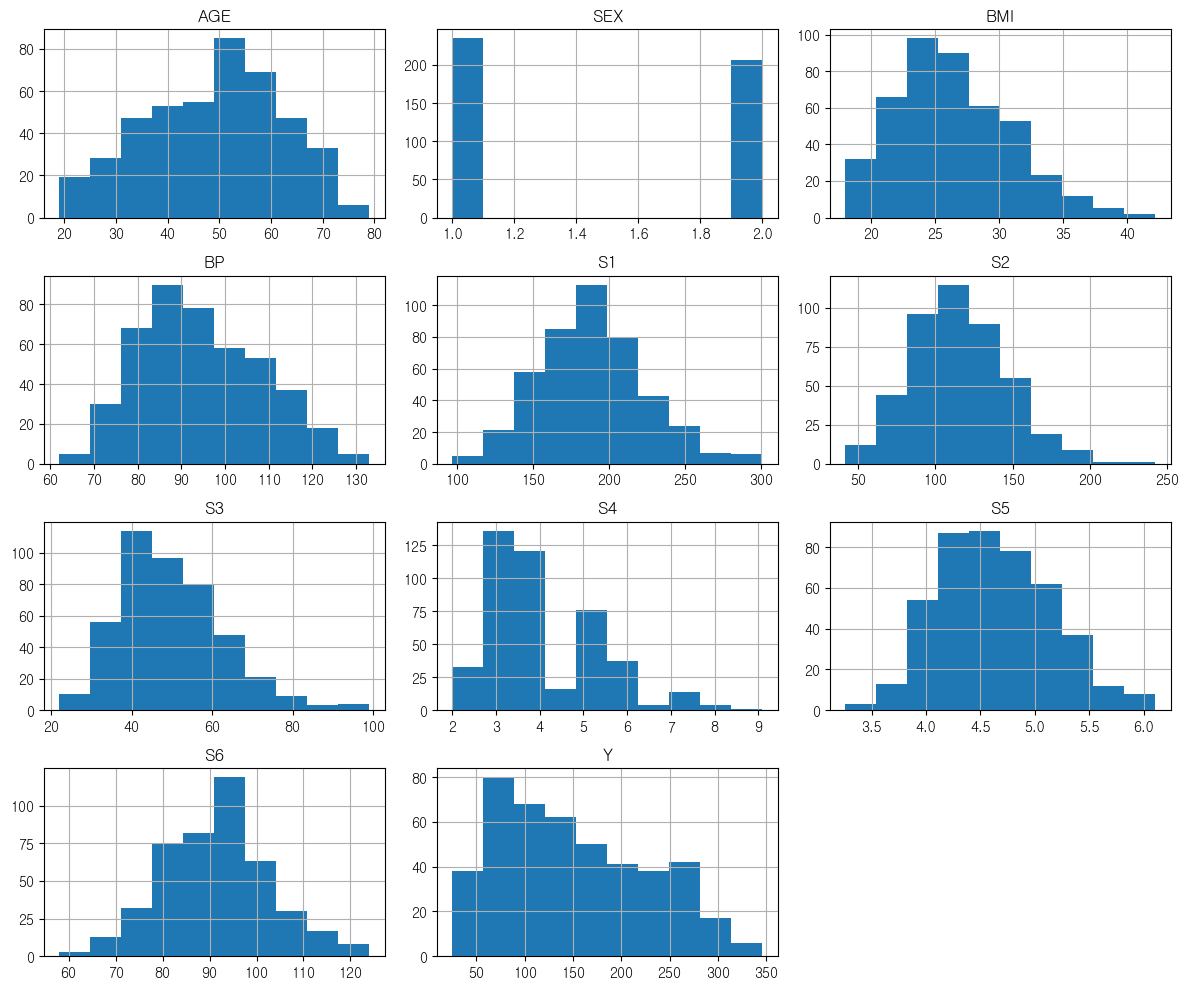

In [363]:
diabetesDF.hist(figsize = (12, 10))
plt.tight_layout()
plt.show()

In [364]:
diabetesDF.nunique()

AGE     58
SEX      2
BMI    163
BP     100
S1     141
S2     302
S3      63
S4      66
S5     184
S6      56
Y      214
dtype: int64

In [365]:
diabetesDF['AGE'].describe()

count    442.000000
mean      48.518100
std       13.109028
min       19.000000
25%       38.250000
50%       50.000000
75%       59.000000
max       79.000000
Name: AGE, dtype: float64

### 데이터 전처리 <hr>

#### 이상치 처리

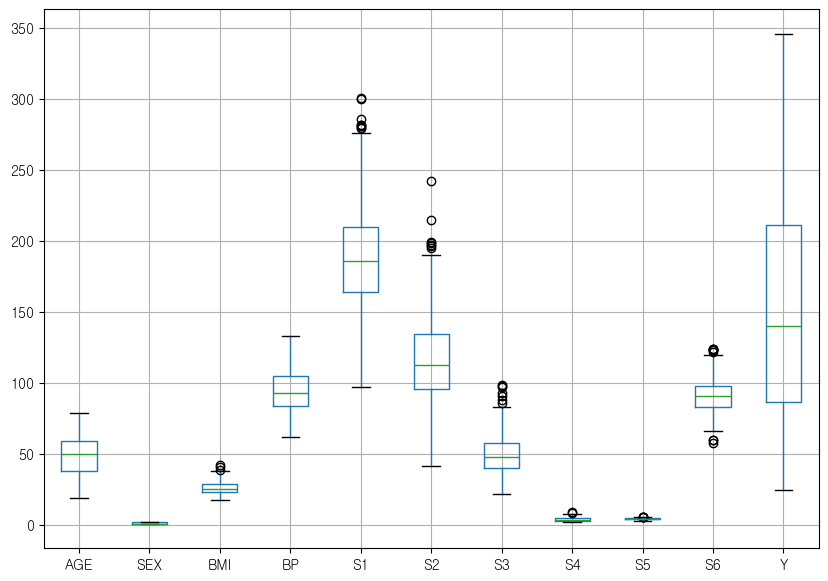

In [366]:
diabetesDF.boxplot(figsize = (10, 7))
plt.show()

In [367]:
# Z-scroe 기반 이상치 탐지 함수
def find_outlier(column_list, scale = 3, df = diabetesDF):
    for col in column_list:
        mean_value = df[col].mean()
        std_value = df[col].std()
        
        base = scale
        z_data = (df[col] - mean_value) / std_value
        mask = z_data.abs() > scale
        print(f'{col} 특성의 이상치 개수 : {z_data[mask].count()}개\n')

In [368]:
diabetesDF.columns

Index(['AGE', 'SEX', 'BMI', 'BP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'Y'], dtype='object')

In [369]:
find_outlier(diabetesDF.columns[2:])

BMI 특성의 이상치 개수 : 2개

BP 특성의 이상치 개수 : 0개

S1 특성의 이상치 개수 : 2개

S2 특성의 이상치 개수 : 2개

S3 특성의 이상치 개수 : 5개

S4 특성의 이상치 개수 : 4개

S5 특성의 이상치 개수 : 0개

S6 특성의 이상치 개수 : 0개

Y 특성의 이상치 개수 : 0개



In [370]:
# Z-score 기반 이상치 제거 함수
def delete_outlier(column_list, scale = 3, df = diabetesDF):
    del_index_list = []
    for col in column_list:
        mean_value = df[col].mean()
        std_value = df[col].std()
        base = scale
        z_data = (df[col] - mean_value) / std_value
        mask = z_data.abs() > base
        index_list = list(df[mask].index)
        del_index_list += index_list
    
    del_index_list = list(set(del_index_list))
    df = df.drop(del_index_list)
    df.reset_index(drop = True, inplace = True)
    
    return df

In [371]:
# Z-score 기반 이상치 제거 후 확인
whitewineDF = delete_outlier(diabetesDF.columns[2:])
whitewineDF.shape

(430, 11)

#### 상관계수 확인

In [372]:
def print_feature(nrows, ncols, target, features, corrs, df = diabetesDF):
    for idx in range(len(features)):
        plt.subplot(nrows, ncols, idx + 1)
        plt.scatter(df[target], df[features[idx]], label = f'corr : {corrs[idx]:.2}', color = 'cornflowerblue')
        plt.xlabel(target)
        plt.ylabel(features[idx])
        plt.legend()
    plt.tight_layout()
    plt.show()

- 수치형 데이터와 타겟의 상관계수

In [373]:
corrList = whitewineDF.corr()['Y'][2:-1]
corrList

BMI    0.574210
BP     0.457891
S1     0.221637
S2     0.176021
S3    -0.387524
S4     0.424691
S5     0.558506
S6     0.379788
Name: Y, dtype: float64

C:\Users\user\AppData\Local\Temp\ipykernel_2400\2075183166.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(df[target], df[features[idx]], label = f'corr : {corrs[idx]:.2}', color = 'cornflowerblue')


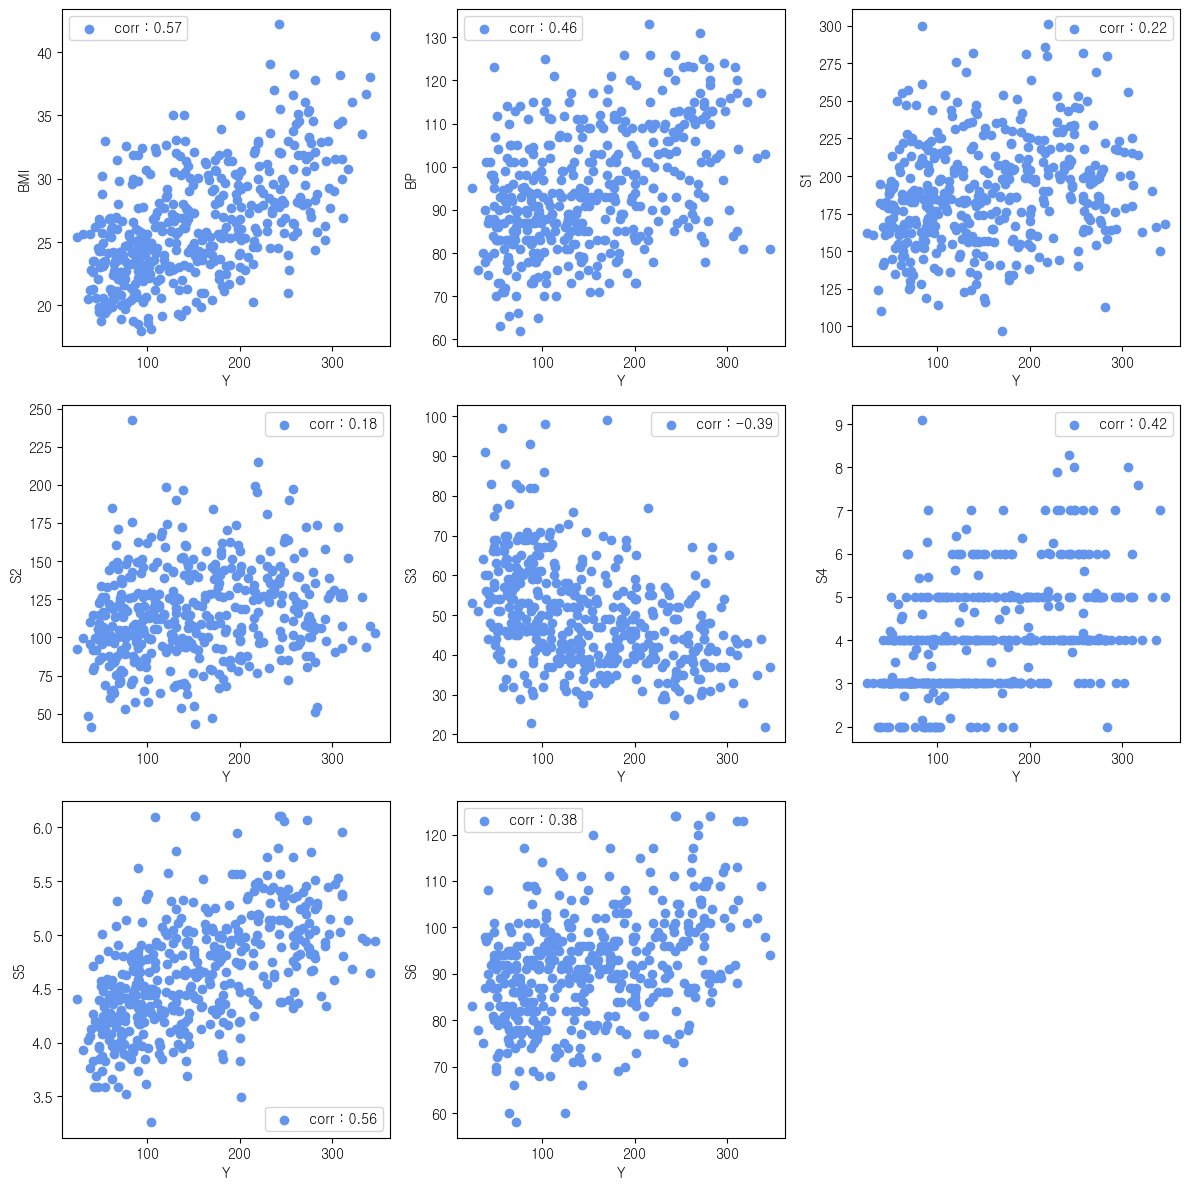

In [374]:
plt.figure(figsize = (12, 12))
print_feature(3, 3, 'Y', whitewineDF.columns[2:-1], corrList)

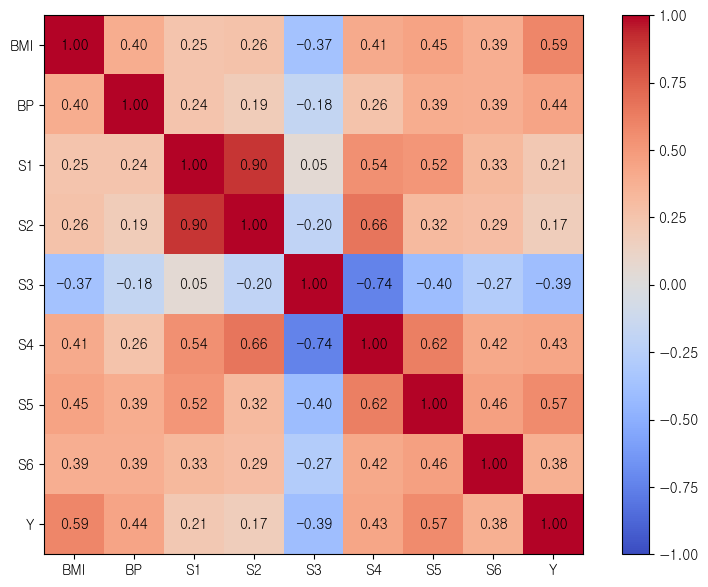

In [375]:
# 상관계수 계산
corr_matrix = diabetesDF[diabetesDF.columns[2:]].corr()

plt.figure(figsize = (10, 7))
# 히트맵으로 상관계수 표시
plt.imshow(corr_matrix, cmap = 'coolwarm', vmin = -1, vmax = 1)

# x축, y축 눈금 설정
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

# 주석 추가
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        text = f'{corr_matrix.iloc[i, j]:.2f}'
        plt.annotate(text, xy = (j, i), ha = 'center', va = 'center')

# 컬러바 추가
plt.colorbar()
plt.show()

- 범주형 데이터와 타겟의 상관계수

In [376]:
# 나이 데이터(순서형)와 타겟의 상관계수

df = diabetesDF[['AGE', 'Y']]
df.corr(method = 'spearman')

,AGE,Y
AGE,1.000000,0.197822
Y,0.197822,1.000000


In [377]:
# 성별 데이터(이진 범주형)와 타겟의 상관계수

stats.pointbiserialr(df.AGE, diabetesDF.Y).statistic

0.1878887507189198

- 피처 수치형 데이터간의 상관계수

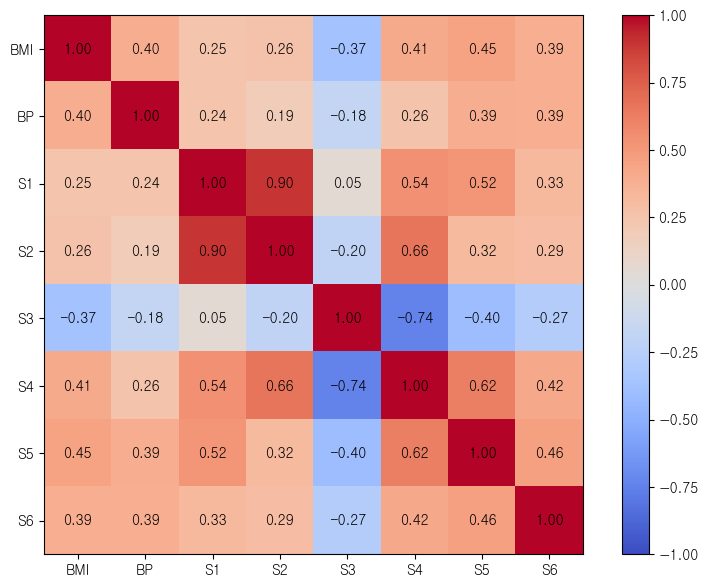

In [378]:
# 상관계수 계산
corr_matrix = diabetesDF[diabetesDF.columns[2:-1]].corr()

plt.figure(figsize = (10, 7))
# 히트맵으로 상관계수 표시
plt.imshow(corr_matrix, cmap = 'coolwarm', vmin = -1, vmax = 1)

# x축, y축 눈금 설정
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

# 주석 추가
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        text = f'{corr_matrix.iloc[i, j]:.2f}'
        plt.annotate(text, xy = (j, i), ha = 'center', va = 'center')

# 컬러바 추가
plt.colorbar()
plt.show()

- AGE 데이터(순서형)와 다른 피처 수치형 데이터의 상관계수  

In [379]:
corrList = diabetesDF.corr(method = 'spearman')['AGE'][2:-1]
corrList

BMI    0.200554
BP     0.350859
S1     0.262524
S2     0.221711
S3    -0.106973
S4     0.221017
S5     0.265176
S6     0.296235
Name: AGE, dtype: float64

C:\Users\user\AppData\Local\Temp\ipykernel_2400\2075183166.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(df[target], df[features[idx]], label = f'corr : {corrs[idx]:.2}', color = 'cornflowerblue')


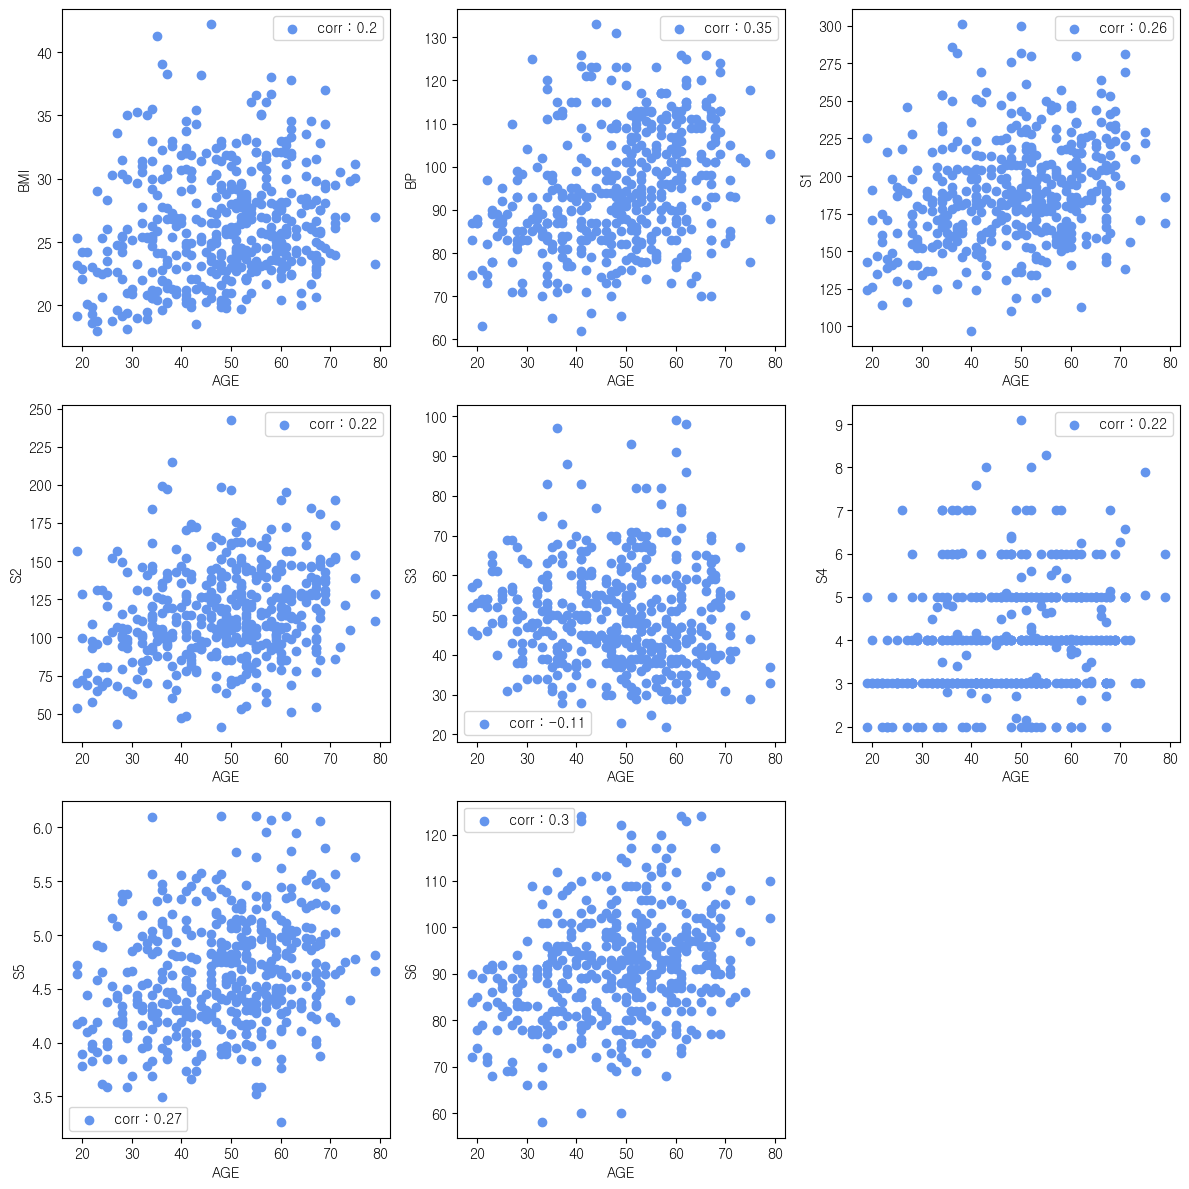

In [380]:
plt.figure(figsize = (12, 12))
print_feature(3, 3, 'AGE', whitewineDF.columns[2:-1], corrList)

- 성별 데이터(이진 범주형)와 다른 수치형 피처 데이터의 상관계수

In [381]:
categorical_dataDF = diabetesDF[['AGE', 'SEX']]
for col in diabetesDF.columns[2:-1]:
    coef = stats.pointbiserialr(categorical_dataDF.SEX, diabetesDF[col]).statistic
    print(f'{col}과 SEX의 Biserial coef는 {coef}\n')

BMI과 SEX의 Biserial coef는 0.0881613990227623

BP과 SEX의 Biserial coef는 0.24101048664904903

S1과 SEX의 Biserial coef는 0.03527681917552948

S2과 SEX의 Biserial coef는 0.14263725703350005

S3과 SEX의 Biserial coef는 -0.3790896292273317

S4과 SEX의 Biserial coef는 0.3321150930829642

S5과 SEX의 Biserial coef는 0.14991613649583813

S6과 SEX의 Biserial coef는 0.20813321620038894



### LinearRegression으로 학습 진행 <hr>

In [382]:
def train_test_set(features, my_scaler = None, target = 'Y', test_size = 0.2, random_state = 42,
                   file_data = 'https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt'):
    df = pd.read_csv(file_data, sep="\t")
    featureDF = df[features]
    targetSR = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(featureDF,
                                                        targetSR,
                                                        test_size = test_size,
                                                        random_state = random_state)
    
    if my_scaler:
        for col in features:
            if col != 'AGE' and col != 'SEX':
                my_scaler.fit(X_train[col].to_frame())
                X_train[col] = my_scaler.transform(X_train[col].to_frame())
                X_test[col] = my_scaler.transform(X_test[col].to_frame())

    
    return X_train, X_test, y_train, y_test

In [383]:
def findoptimal(features, my_scaler = None, max_k = 50,
                weights = 'uniform', metric = 'minkowski', p = 2, algorithm = 'auto',
                my_model = KNeighborsRegressor()):
    
    X_train, X_test, y_train, y_test = train_test_set(features, my_scaler)
   
    if my_model.__class__ == KNeighborsRegressor:
        train_scoreList = []
        test_scoreList = []
        for k in range(1, max_k + 1):
            model = KNeighborsRegressor(n_neighbors = k,
                                        weights = weights,
                                        metric = metric, p = p,
                                        algorithm = algorithm)
            model.fit(X_train, y_train)
            train_scoreList.append(model.score(X_train, y_train))
            test_scoreList.append(model.score(X_test, y_test))
        
        # k에 따른 학습용/테스트용 점수 시각화
        # plt.plot(train_scoreList, 'b--', label = 'Train score')
        # plt.plot(test_scoreList, 'r', label = 'Test score')
        # plt.title('k & Score')
        # plt.xlabel('k')
        # plt.ylabel('Score')
        # plt.legend()
        # plt.show()    
    
        # print(f'최적의 이웃 개수 k = {test_scoreList.index(max(test_scoreList))+1}')
        max_test_score = max(test_scoreList)
        optimal_k = test_scoreList.index(max_test_score)+1
        model = KNeighborsRegressor(n_neighbors = optimal_k,
                                    weights = weights,
                                    metric = metric, p = p,
                                    algorithm = algorithm)
        model.fit(X_train, y_train)
        return round(model.score(X_train, y_train), 2), round(model.score(X_test, y_test), 2)
        #print(f'train score는 k = {train_scoreList.index(max(train_scoreList))+1}일 때 최댓값 {max(train_scoreList)}을 갖는다.')
        #print(f'test score는 k = {test_scoreList.index(max(test_scoreList))+1}일 때 최댓값 {max(test_scoreList)}을 갖는다.')
    elif my_model.__class__ == LinearRegression:   
        my_model.fit(X_train, y_train)
        
        if len(features) > 1:
            # 학습 후 속성 확인
            print(f'피처에 할당되는 가중치 계수 : {my_model.coef_}\n')
            print(f'수식에 사용되는 절편 계수 : {my_model.intercept_}\n')

            # score 메서드는 결정계수 R2를 반환
            print(f'train score => {my_model.score(X_train, y_train)}\n')
            print(f'test score => {my_model.score(X_test, y_test)}\n')
            y_pre = my_model.predict(X_test)
            print(f'결정계수 R2 ==> {r2_score(y_test, y_pre)}\n')
            print(f'평균 절댓값 오차 ==> {mean_absolute_error(y_test, y_pre)}\n')
            print(f'평균제곱 오차 ==> {mean_squared_error(y_test, y_pre)}\n')
            print(f'루트 평균제곱 오차 ==> {mean_squared_error(y_test, y_pre, squared = False)}')
        return my_model.score(X_train, y_train), my_model.score(X_test, y_test), my_model.coef_, my_model.intercept_

#### 피처 한개 사용

In [384]:
def scatter_polyfit(nrows, ncols, target, features):
    for idx in range(len(features)):
        plt.subplot(nrows, ncols, idx + 1)
        X_train, X_test, y_train, y_test = train_test_set([features[idx]])
        corr = np.corrcoef(X_train.values.reshape(1, -1), y_train.values)
        plt.scatter(X_train.values, y_train.values, label = f'corr : {corr[0, 1]:.2}', color = 'cornflowerblue')
        plt.xlabel(features[idx])
        plt.ylabel(target)
        train_score, test_score, coefficient, intercept = findoptimal([features[idx]], my_model = LinearRegression())
        max_value = X_train[features[idx]].max()
        min_value = X_train[features[idx]].min()
        x = np.arange(min_value, max_value + 1)
        plt.plot(x, coefficient*x + intercept, color = 'r')
        plt.title(f'train r2 score : {train_score}, test r2 score : {test_score}')
        plt.legend()
    plt.tight_layout()
    plt.show()

In [385]:
diabetesDF.columns[2:-1][0]

'BMI'

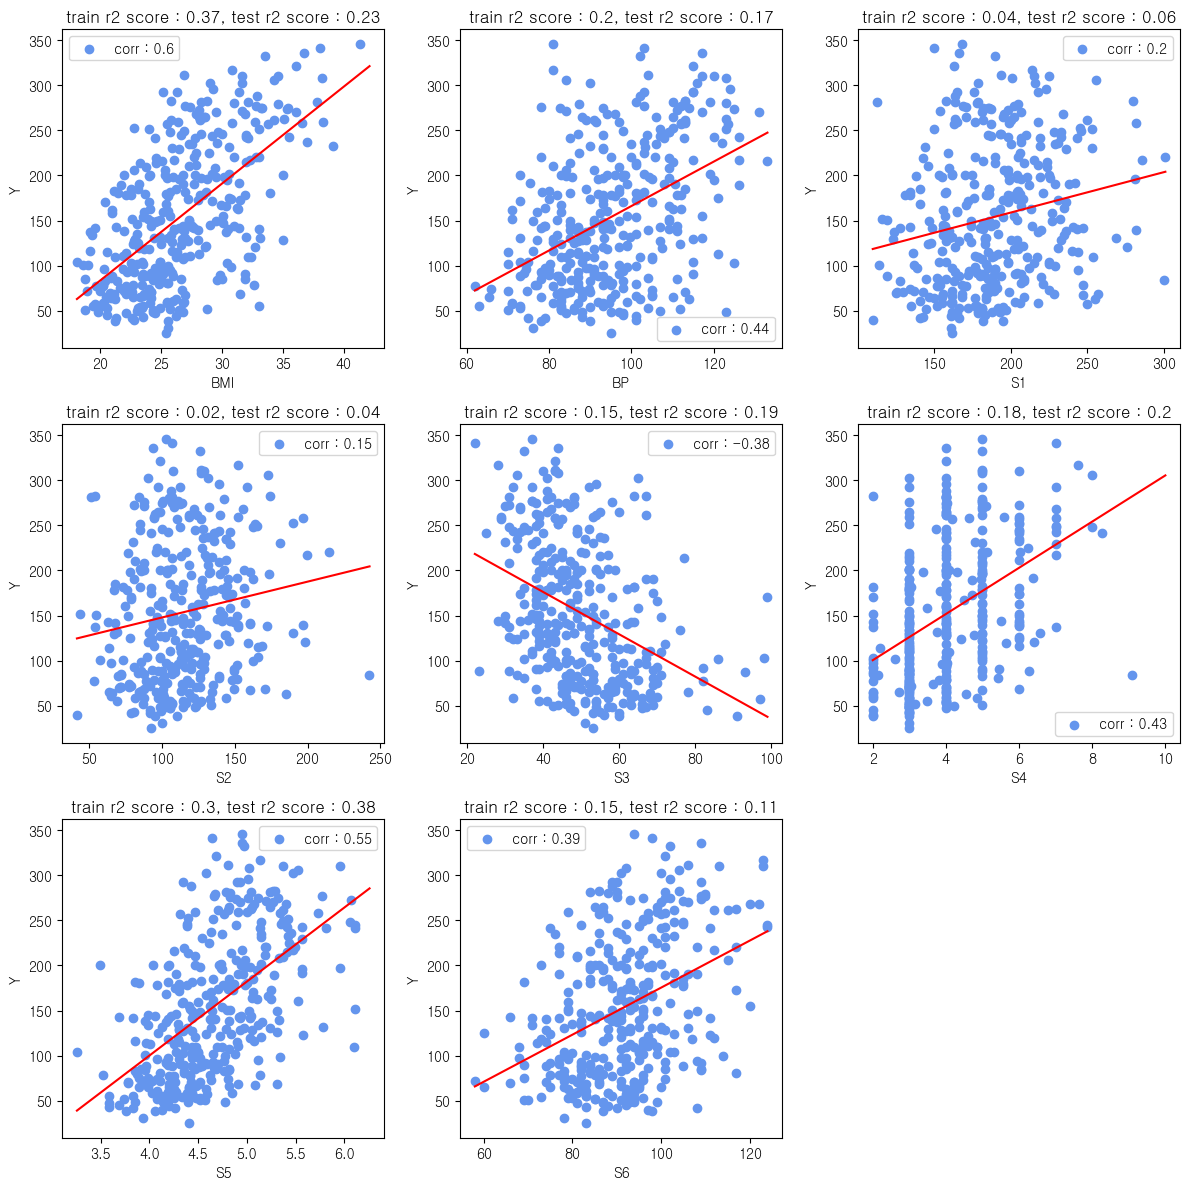

In [386]:
plt.figure(figsize = (12, 12))
scatter_polyfit(3, 3, 'Y', diabetesDF.columns[2:-1])

#### BMI, BP, S5 3개 피처 사용

In [387]:
scaled_X_train, scaled_X_test, y_train, y_test = train_test_set(['BMI', 'BP', 'S5'], StandardScaler())

In [388]:
print(f'X_train shape ==> {scaled_X_train.shape}, y_trian shape ==> {y_train.shape}\n')
print(f'X_test shape ==> {scaled_X_test.shape}, y_test shape ==> {y_test.shape}')

X_train shape ==> (353, 3), y_trian shape ==> (353,)

X_test shape ==> (89, 3), y_test shape ==> (89,)


In [389]:
findoptimal(['BMI', 'BP', 'S5'], my_scaler = None, max_k = 50, weights = 'uniform', metric = 'minkowski', p = 2, algorithm = 'auto', my_model = LinearRegression())

피처에 할당되는 가중치 계수 : [ 7.01258361  0.97742161 44.8471889 ]

수식에 사용되는 절편 계수 : -333.9525481992771

train score => 0.4831394939699334

test score => 0.4543309915384338

결정계수 R2 ==> 0.4543309915384338

평균 절댓값 오차 ==> 44.28819577506335

평균제곱 오차 ==> 2891.0372112919667

루트 평균제곱 오차 ==> 53.76836626950801


(0.48,
 0.45,
 array([ 7.01258361,  0.97742161, 44.8471889 ]),
 -333.9525481992771)

#### BMI, BP, S3, S5 4개 피처 사용

In [390]:
scaled_X_train, scaled_X_test, y_train, y_test = train_test_set(['BMI', 'BP', 'S3', 'S5'], StandardScaler())

In [391]:
print(f'X_train shape ==> {scaled_X_train.shape}, y_trian shape ==> {y_train.shape}\n')
print(f'X_test shape ==> {scaled_X_test.shape}, y_test shape ==> {y_test.shape}')

X_train shape ==> (353, 4), y_trian shape ==> (353,)

X_test shape ==> (89, 4), y_test shape ==> (89,)


In [392]:
findoptimal(['BMI', 'BP', 'S3', 'S5'], my_scaler = None, max_k = 50, weights = 'uniform', metric = 'minkowski', p = 2, algorithm = 'auto', my_model = LinearRegression())

피처에 할당되는 가중치 계수 : [ 6.39477199  1.04300859 -0.83107748 39.0682958 ]

수식에 사용되는 절편 계수 : -255.73374220603412

train score => 0.49819761458410716

test score => 0.44701797732863346

결정계수 R2 ==> 0.44701797732863346

평균 절댓값 오차 ==> 44.04475025054916

평균제곱 오차 ==> 2929.7826703145474

루트 평균제곱 오차 ==> 54.12746687509538


(0.5,
 0.45,
 array([ 6.39477199,  1.04300859, -0.83107748, 39.0682958 ]),
 -255.73374220603412)

#### 전체 피처 사용

In [393]:
findoptimal(diabetesDF.columns[:-1], my_scaler = None, max_k = 50, weights = 'uniform', metric = 'minkowski', p = 2, algorithm = 'auto', my_model = LinearRegression())

피처에 할당되는 가중치 계수 : [  0.13768782 -23.06446772   5.84636265   1.19709252  -1.28168474
   0.81115203   0.60165319  10.15953917  67.1089624    0.20159907]

수식에 사용되는 절편 계수 : -341.3782363335058

train score => 0.5279193863361497

test score => 0.4526027629719195

결정계수 R2 ==> 0.4526027629719195

평균 절댓값 오차 ==> 42.79409467959994

평균제곱 오차 ==> 2900.1936284934814

루트 평균제곱 오차 ==> 53.85344583676593


(0.53,
 0.45,
 array([  0.13768782, -23.06446772,   5.84636265,   1.19709252,
         -1.28168474,   0.81115203,   0.60165319,  10.15953917,
         67.1089624 ,   0.20159907]),
 -341.3782363335058)

### KNeighborsRegressor로 학습 진행 <hr>

#### BMI, BP, S5 3개 피처 사용

In [394]:
for scaler in [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), QuantileTransformer()]:
    for weights in ['uniform', 'distance']:                   
        for p in [1, 2, 3]:
            for metric in ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan', 'nan_euclidean']:
                train_score, test_score = findoptimal(['BMI', 'BP', 'S5'], scaler, weights = weights, metric = metric, p = p, my_model = KNeighborsRegressor())
                print(f"scaler => {scaler}, weight => {weights}, p => {p}, metric => {metric}, train score => {train_score}, test score => {test_score}\n")

scaler => StandardScaler(), weight => uniform, p => 1, metric => cityblock, train score => 0.49, test score => 0.5

scaler => StandardScaler(), weight => uniform, p => 1, metric => cosine, train score => 0.46, test score => 0.47

scaler => StandardScaler(), weight => uniform, p => 1, metric => euclidean, train score => 0.49, test score => 0.51

scaler => StandardScaler(), weight => uniform, p => 1, metric => l1, train score => 0.49, test score => 0.5

scaler => StandardScaler(), weight => uniform, p => 1, metric => l2, train score => 0.49, test score => 0.51

scaler => StandardScaler(), weight => uniform, p => 1, metric => manhattan, train score => 0.49, test score => 0.5

scaler => StandardScaler(), weight => uniform, p => 1, metric => nan_euclidean, train score => 0.49, test score => 0.51

scaler => StandardScaler(), weight => uniform, p => 2, metric => cityblock, train score => 0.49, test score => 0.5

scaler => StandardScaler(), weight => uniform, p => 2, metric => cosine, train sc

c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 1, metric => cityblock, train score => 0.49, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 1, metric => cosine, train score => 0.22, test score => 0.15



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 1, metric => euclidean, train score => 0.48, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 1, metric => l1, train score => 0.49, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 1, metric => l2, train score => 0.48, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 1, metric => manhattan, train score => 0.49, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 1, metric => nan_euclidean, train score => 0.48, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 2, metric => cityblock, train score => 0.49, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 2, metric => cosine, train score => 0.22, test score => 0.15



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 2, metric => euclidean, train score => 0.48, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 2, metric => l1, train score => 0.49, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 2, metric => l2, train score => 0.48, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 2, metric => manhattan, train score => 0.49, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 2, metric => nan_euclidean, train score => 0.48, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 3, metric => cityblock, train score => 0.49, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 3, metric => cosine, train score => 0.22, test score => 0.15



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 3, metric => euclidean, train score => 0.48, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 3, metric => l1, train score => 0.49, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 3, metric => l2, train score => 0.48, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 3, metric => manhattan, train score => 0.49, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 3, metric => nan_euclidean, train score => 0.48, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 1, metric => cityblock, train score => 1.0, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 1, metric => cosine, train score => 1.0, test score => 0.06



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 1, metric => euclidean, train score => 1.0, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 1, metric => l1, train score => 1.0, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 1, metric => l2, train score => 1.0, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 1, metric => manhattan, train score => 1.0, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 1, metric => nan_euclidean, train score => 1.0, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 2, metric => cityblock, train score => 1.0, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 2, metric => cosine, train score => 1.0, test score => 0.06



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 2, metric => euclidean, train score => 1.0, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 2, metric => l1, train score => 1.0, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 2, metric => l2, train score => 1.0, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 2, metric => manhattan, train score => 1.0, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 2, metric => nan_euclidean, train score => 1.0, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 3, metric => cityblock, train score => 1.0, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 3, metric => cosine, train score => 1.0, test score => 0.06



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 3, metric => euclidean, train score => 1.0, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 3, metric => l1, train score => 1.0, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 3, metric => l2, train score => 1.0, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 3, metric => manhattan, train score => 1.0, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 3, metric => nan_euclidean, train score => 1.0, test score => 0.5



#### BMI, BP, S3, S5 4개 피처 사용

In [395]:
for scaler in [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), QuantileTransformer()]:
    for weights in ['uniform', 'distance']:                   
        for p in [1, 2, 3]:
            for metric in ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan', 'nan_euclidean']:
                train_score, test_score = findoptimal(['BMI', 'BP', 'S3', 'S5'], scaler, weights = weights, metric = metric, p = p, my_model = KNeighborsRegressor())
                print(f"scaler => {scaler}, weight => {weights}, p => {p}, metric => {metric}, train score => {train_score}, test score => {test_score}\n")

scaler => StandardScaler(), weight => uniform, p => 1, metric => cityblock, train score => 0.49, test score => 0.5

scaler => StandardScaler(), weight => uniform, p => 1, metric => cosine, train score => 0.46, test score => 0.45

scaler => StandardScaler(), weight => uniform, p => 1, metric => euclidean, train score => 0.48, test score => 0.49

scaler => StandardScaler(), weight => uniform, p => 1, metric => l1, train score => 0.49, test score => 0.5

scaler => StandardScaler(), weight => uniform, p => 1, metric => l2, train score => 0.48, test score => 0.49

scaler => StandardScaler(), weight => uniform, p => 1, metric => manhattan, train score => 0.49, test score => 0.5

scaler => StandardScaler(), weight => uniform, p => 1, metric => nan_euclidean, train score => 0.48, test score => 0.49

scaler => StandardScaler(), weight => uniform, p => 2, metric => cityblock, train score => 0.49, test score => 0.5

scaler => StandardScaler(), weight => uniform, p => 2, metric => cosine, train sc

c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 1, metric => cityblock, train score => 0.49, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 1, metric => cosine, train score => 0.4, test score => 0.32



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 1, metric => euclidean, train score => 0.48, test score => 0.49



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 1, metric => l1, train score => 0.49, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 1, metric => l2, train score => 0.48, test score => 0.49



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 1, metric => manhattan, train score => 0.49, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 1, metric => nan_euclidean, train score => 0.48, test score => 0.49



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 2, metric => cityblock, train score => 0.49, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 2, metric => cosine, train score => 0.4, test score => 0.32



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 2, metric => euclidean, train score => 0.48, test score => 0.49



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 2, metric => l1, train score => 0.49, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 2, metric => l2, train score => 0.48, test score => 0.49



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 2, metric => manhattan, train score => 0.49, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 2, metric => nan_euclidean, train score => 0.48, test score => 0.49



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 3, metric => cityblock, train score => 0.49, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 3, metric => cosine, train score => 0.4, test score => 0.32



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 3, metric => euclidean, train score => 0.48, test score => 0.49



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 3, metric => l1, train score => 0.49, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 3, metric => l2, train score => 0.48, test score => 0.49



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 3, metric => manhattan, train score => 0.49, test score => 0.5



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => uniform, p => 3, metric => nan_euclidean, train score => 0.48, test score => 0.49



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 1, metric => cityblock, train score => 1.0, test score => 0.49



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 1, metric => cosine, train score => 1.0, test score => 0.27



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 1, metric => euclidean, train score => 1.0, test score => 0.48



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 1, metric => l1, train score => 1.0, test score => 0.49



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 1, metric => l2, train score => 1.0, test score => 0.48



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 1, metric => manhattan, train score => 1.0, test score => 0.49



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 1, metric => nan_euclidean, train score => 1.0, test score => 0.48



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 2, metric => cityblock, train score => 1.0, test score => 0.49



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 2, metric => cosine, train score => 1.0, test score => 0.27



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 2, metric => euclidean, train score => 1.0, test score => 0.48



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 2, metric => l1, train score => 1.0, test score => 0.49



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 2, metric => l2, train score => 1.0, test score => 0.48



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 2, metric => manhattan, train score => 1.0, test score => 0.49



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 2, metric => nan_euclidean, train score => 1.0, test score => 0.48



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 3, metric => cityblock, train score => 1.0, test score => 0.49



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 3, metric => cosine, train score => 1.0, test score => 0.27



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 3, metric => euclidean, train score => 1.0, test score => 0.48



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 3, metric => l1, train score => 1.0, test score => 0.49



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 3, metric => l2, train score => 1.0, test score => 0.48



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 3, metric => manhattan, train score => 1.0, test score => 0.49



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(


scaler => QuantileTransformer(), weight => distance, p => 3, metric => nan_euclidean, train score => 1.0, test score => 0.48



#### 전체 피처 사용

In [397]:
for scaler in [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), QuantileTransformer()]:
    for weights in ['uniform', 'distance']:                   
        for p in [1, 2, 3]:
            for metric in ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan', 'nan_euclidean']:
                train_score, test_score = findoptimal(diabetesDF.columns[2:-1], scaler, weights = weights, metric = metric, p = p, my_model = KNeighborsRegressor())
                print(f"scaler => {scaler}, weight => {weights}, p => {p}, metric => {metric}, train score => {train_score}, test score => {test_score}\n")

scaler => StandardScaler(), weight => uniform, p => 1, metric => cityblock, train score => 0.52, test score => 0.45

scaler => StandardScaler(), weight => uniform, p => 1, metric => cosine, train score => 0.54, test score => 0.47

scaler => StandardScaler(), weight => uniform, p => 1, metric => euclidean, train score => 0.51, test score => 0.46

scaler => StandardScaler(), weight => uniform, p => 1, metric => l1, train score => 0.52, test score => 0.45

scaler => StandardScaler(), weight => uniform, p => 1, metric => l2, train score => 0.51, test score => 0.46

scaler => StandardScaler(), weight => uniform, p => 1, metric => manhattan, train score => 0.52, test score => 0.45

scaler => StandardScaler(), weight => uniform, p => 1, metric => nan_euclidean, train score => 0.51, test score => 0.46

scaler => StandardScaler(), weight => uniform, p => 2, metric => cityblock, train score => 0.52, test score => 0.45

scaler => StandardScaler(), weight => uniform, p => 2, metric => cosine, trai

c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => uniform, p => 1, metric => cityblock, train score => 0.55, test score => 0.44



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => uniform, p => 1, metric => cosine, train score => 0.43, test score => 0.35



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => uniform, p => 1, metric => euclidean, train score => 0.52, test score => 0.44



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => uniform, p => 1, metric => l1, train score => 0.55, test score => 0.44



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => uniform, p => 1, metric => l2, train score => 0.52, test score => 0.44



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => uniform, p => 1, metric => manhattan, train score => 0.55, test score => 0.44



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => uniform, p => 1, metric => nan_euclidean, train score => 0.52, test score => 0.44



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => uniform, p => 2, metric => cityblock, train score => 0.55, test score => 0.44



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => uniform, p => 2, metric => cosine, train score => 0.43, test score => 0.35



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => uniform, p => 2, metric => euclidean, train score => 0.52, test score => 0.44



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => uniform, p => 2, metric => l1, train score => 0.55, test score => 0.44



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => uniform, p => 2, metric => l2, train score => 0.52, test score => 0.44



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => uniform, p => 2, metric => manhattan, train score => 0.55, test score => 0.44



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => uniform, p => 2, metric => nan_euclidean, train score => 0.52, test score => 0.44



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => uniform, p => 3, metric => cityblock, train score => 0.55, test score => 0.44



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => uniform, p => 3, metric => cosine, train score => 0.43, test score => 0.35



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => uniform, p => 3, metric => euclidean, train score => 0.52, test score => 0.44



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => uniform, p => 3, metric => l1, train score => 0.55, test score => 0.44



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => uniform, p => 3, metric => l2, train score => 0.52, test score => 0.44



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => uniform, p => 3, metric => manhattan, train score => 0.55, test score => 0.44



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => uniform, p => 3, metric => nan_euclidean, train score => 0.52, test score => 0.44



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => distance, p => 1, metric => cityblock, train score => 1.0, test score => 0.45



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => distance, p => 1, metric => cosine, train score => 1.0, test score => 0.35



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => distance, p => 1, metric => euclidean, train score => 1.0, test score => 0.45



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => distance, p => 1, metric => l1, train score => 1.0, test score => 0.45



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => distance, p => 1, metric => l2, train score => 1.0, test score => 0.45



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => distance, p => 1, metric => manhattan, train score => 1.0, test score => 0.45



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => distance, p => 1, metric => nan_euclidean, train score => 1.0, test score => 0.45



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => distance, p => 2, metric => cityblock, train score => 1.0, test score => 0.45



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => distance, p => 2, metric => cosine, train score => 1.0, test score => 0.35



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => distance, p => 2, metric => euclidean, train score => 1.0, test score => 0.45



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => distance, p => 2, metric => l1, train score => 1.0, test score => 0.45



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => distance, p => 2, metric => l2, train score => 1.0, test score => 0.45



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => distance, p => 2, metric => manhattan, train score => 1.0, test score => 0.45



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => distance, p => 2, metric => nan_euclidean, train score => 1.0, test score => 0.45



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => distance, p => 3, metric => cityblock, train score => 1.0, test score => 0.45



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => distance, p => 3, metric => cosine, train score => 1.0, test score => 0.35



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => distance, p => 3, metric => euclidean, train score => 1.0, test score => 0.45



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => distance, p => 3, metric => l1, train score => 1.0, test score => 0.45



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => distance, p => 3, metric => l2, train score => 1.0, test score => 0.45



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => distance, p => 3, metric => manhattan, train score => 1.0, test score => 0.45



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_qua

scaler => QuantileTransformer(), weight => distance, p => 3, metric => nan_euclidean, train score => 1.0, test score => 0.45



In [ ]:
cut = pd.cut(diabetesDF['AGE'].values, bins = [i for i in range(10, 81, 10)])
cut.describe()

,counts,freqs
categories,,
"(10, 20]",6,0.013575
"(20, 30]",41,0.092760
"(30, 40]",75,0.169683
"(40, 50]",105,0.237557
"(50, 60]",129,0.291855
"(60, 70]",74,0.167421
"(70, 80]",12,0.027149


In [ ]:
import math
math.trunc(65/10) * 10

60

In [ ]:
diabetesDF['AGE'].apply(lambda x : math.trunc(x/10) * 10)

0      50
1      40
2      70
3      20
4      50
       ..
408    60
409    40
410    60
411    30
412    30
Name: AGE, Length: 413, dtype: int64

In [ ]:
cut.describe()['freqs'].values

array([0.01357466, 0.09276018, 0.16968326, 0.23755656, 0.2918552 ,
       0.16742081, 0.02714932])

In [ ]:
cut.describe()['counts'].values

array([  6,  41,  75, 105, 129,  74,  12], dtype=int64)